In [10]:
# This code is to take multiple on-chain data and test the unidirectional Garenger causality. For further information please refer to https://phdinds-aim.github.io/time_series_handbook/Preface/Preface.html
import json
import requests
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import lag_plot
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import acf, ccf, ccovf,adfuller, kpss
import warnings
warnings.filterwarnings("ignore")


ModuleNotFoundError: No module named 'requests'

In [201]:
# insert your API key, Start Date & End Date
current_date = datetime.now()
delta_date = 365
start_date = int(datetime.timestamp(current_date-timedelta(days = delta_date)))
end_date = int(datetime.timestamp(current_date))
API_KEY = '2B1pxzrRCwECISMvVhDJ5c3jt'

# make API request for Price
res_y = requests.get('https://api.glassnode.com/v1/metrics/market/price_usd_close',
    params={'a': 'BTC', 's': start_date, 'u': end_date, 'api_key': API_KEY})
df_y = pd.read_json(res_y.text, convert_dates=['t'])


url_list = ['https://api.glassnode.com/v1/metrics/indicators/sopr_less_155',
            'https://api.glassnode.com/v1/metrics/indicators/sopr_adjusted',
            'https://api.glassnode.com/v1/metrics/indicators/sopr_more_155',
            'https://api.glassnode.com/v1/metrics/indicators/sopr']

# make API request for X = STH-SOPR & Y = Price
i = 0
res_x = []
df_x = []
for url in url_list:
    res_x.append(requests.get(url,params={'a': 'BTC', 's': start_date, 'u': end_date, 'api_key': API_KEY}))
    df_x.append(pd.read_json(res_x[i].text, convert_dates=['t']))
    i = i+1

# concat all values from dfs
df = df_y['v']
for dfx in df_x:
    df = pd.concat([df,dfx['v']], axis=1)
df.columns =['PRICE']+ [url.split("/")[-1:][0].upper() for url in url_list]
print(df.head(5))

          PRICE  SOPR_LESS_155  SOPR_ADJUSTED  SOPR_MORE_155      SOPR
0  16915.710105       0.998157       0.979847       0.498420  0.992029
1  17137.597161       1.000897       0.952708       0.428941  0.979081
2  16974.709590       0.998625       0.873267       0.416021  0.937525
3  17085.275988       0.999037       0.948345       0.376352  0.975163
4  16850.772516       0.991092       0.985423       0.717222  0.994614


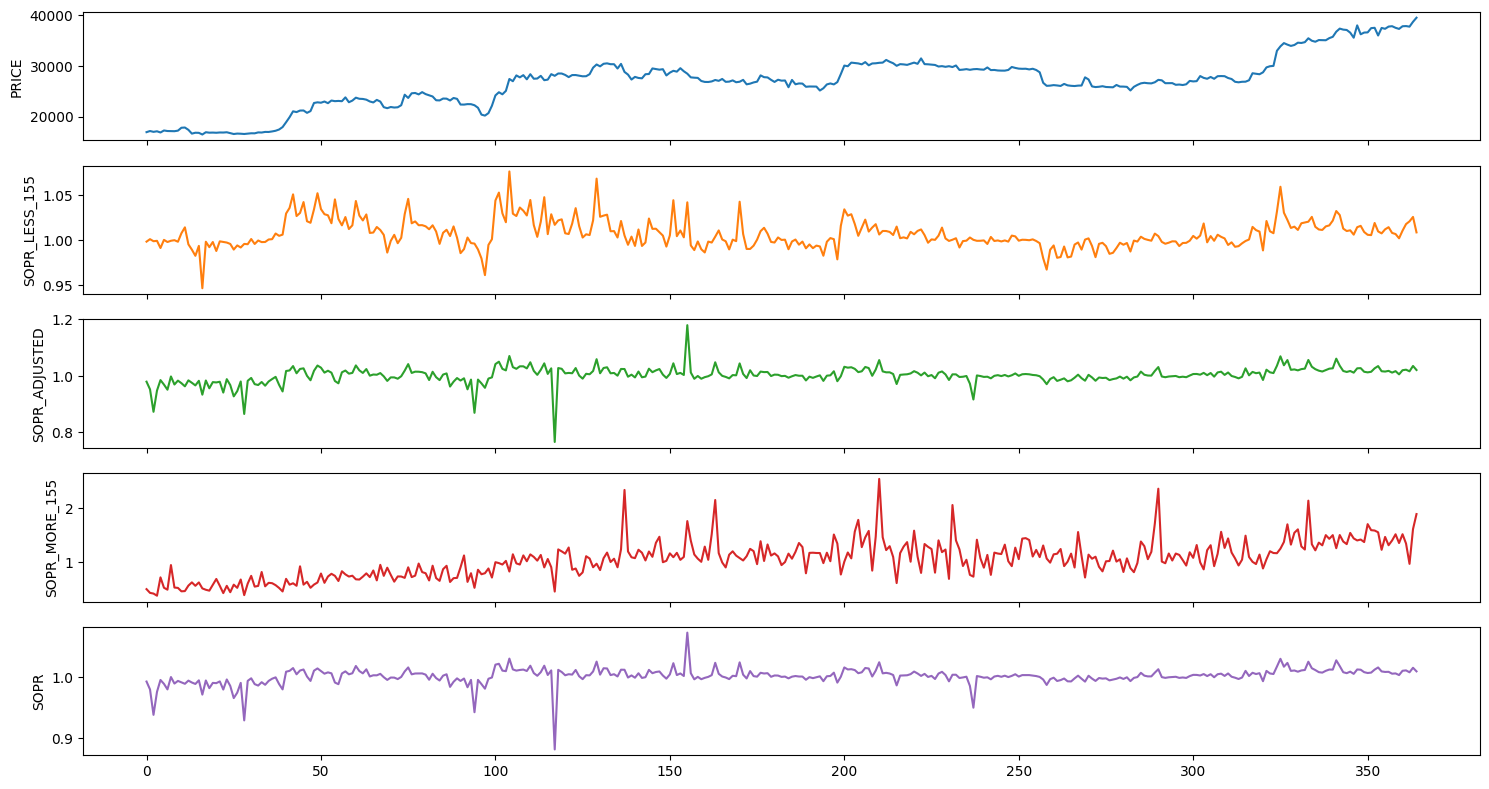

In [202]:
fig,ax = plt.subplots(df.shape[1], figsize=(15,8), sharex=True)
df.plot(subplots=True, legend=False, ax=ax)
for a in range(len(ax)): 
    ax[a].set_ylabel(df.columns[a])
ax[-1].set_xlabel('')
plt.tight_layout()
plt.show()

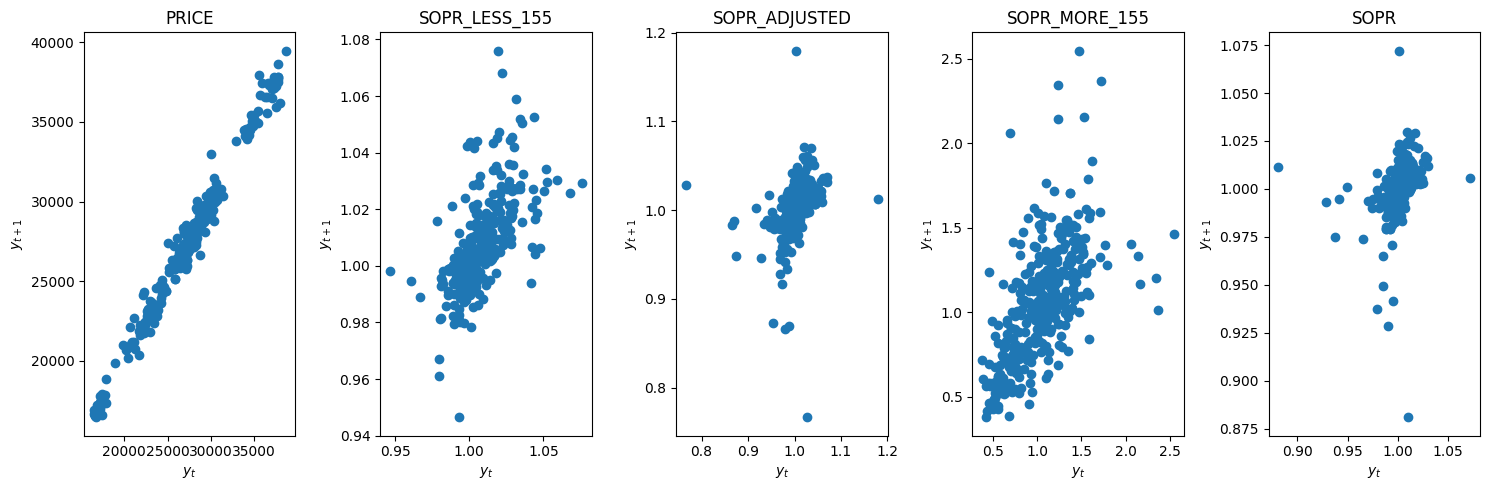

In [203]:
#lag plots to quickly check for stationarity

def lag_plots(data_df):
    f, ax= plt.subplots(1, data_df.shape[1], figsize=(15, 5))
    for i in range(data_df.shape[1]):
        lag_plot(data_df[data_df.columns[i]], ax=ax[i])
        ax[i].set_title(data_df.columns[i]);
        ax[i].set_ylabel('$y_{t+1}$');
        ax[i].set_xlabel('$y_t$');
    plt.tight_layout()
lag_plots(df)

In [204]:
#Use KPSS and ADF teststo conclusively check for stationarity
def kpss_test(data_df):
    test_stat, p_val = [], []
    cv_1pct, cv_2p5pct, cv_5pct, cv_10pct = [], [], [], []
    for c in data_df.columns: 
        kpss_res = kpss(data_df[c].dropna(), regression='ct')
        test_stat.append(kpss_res[0])
        p_val.append(kpss_res[1])
        cv_1pct.append(kpss_res[3]['1%'])
        cv_2p5pct.append(kpss_res[3]['2.5%'])
        cv_5pct.append(kpss_res[3]['5%'])
        cv_10pct.append(kpss_res[3]['10%'])
    kpss_res_df = pd.DataFrame({'Test statistic': test_stat, 
                               'p-value': p_val, 
                               'Critical value - 1%': cv_1pct,
                               'Critical value - 2.5%': cv_2p5pct,
                               'Critical value - 5%': cv_5pct,
                               'Critical value - 10%': cv_10pct}, 
                             index=data_df.columns).T
    kpss_res_df = kpss_res_df.round(4)
    return kpss_res_df

In [205]:
kpss_test(df)

,PRICE,SOPR_LESS_155,SOPR_ADJUSTED,SOPR_MORE_155,SOPR
Test statistic,0.2967,0.1811,0.2309,0.5092,0.2287
p-value,0.0100,0.0231,0.0100,0.0100,0.0100
Critical value - 1%,0.2160,0.2160,0.2160,0.2160,0.2160
Critical value - 2.5%,0.1760,0.1760,0.1760,0.1760,0.1760
Critical value - 5%,0.1460,0.1460,0.1460,0.1460,0.1460
Critical value - 10%,0.1190,0.1190,0.1190,0.1190,0.1190


In [206]:
def adf_test(data_df):
    test_stat, p_val = [], []
    cv_1pct, cv_5pct, cv_10pct = [], [], []
    for c in data_df.columns: 
        adf_res = adfuller(data_df[c].dropna())
        test_stat.append(adf_res[0])
        p_val.append(adf_res[1])
        cv_1pct.append(adf_res[4]['1%'])
        cv_5pct.append(adf_res[4]['5%'])
        cv_10pct.append(adf_res[4]['10%'])
    adf_res_df = pd.DataFrame({'Test statistic': test_stat, 
                               'p-value': p_val, 
                               'Critical value - 1%': cv_1pct,
                               'Critical value - 5%': cv_5pct,
                               'Critical value - 10%': cv_10pct}, 
                             index=data_df.columns).T
    adf_res_df = adf_res_df.round(4)
    return adf_res_df

In [207]:
df_adf = adf_test(df)
adf_test(df)

,PRICE,SOPR_LESS_155,SOPR_ADJUSTED,SOPR_MORE_155,SOPR
Test statistic,-0.5660,-3.8492,-5.8084,-1.4319,-6.1573
p-value,0.8785,0.0024,0.0000,0.5669,0.0000
Critical value - 1%,-3.4484,-3.4487,-3.4486,-3.4493,-3.4486
Critical value - 5%,-2.8695,-2.8696,-2.8696,-2.8699,-2.8696
Critical value - 10%,-2.5710,-2.5711,-2.5711,-2.5712,-2.5711


In [224]:
# use diff for non-stationary variables 
i = 0
diff_applied = []
for p_value in df_adf.iloc[1,:]:
    if p_value > 0.05:
        df.iloc[:,i] = df.iloc[:,i]- df.iloc[:,i].shift(1)
        diff_applied.append(True)
    else:
        diff_applied.append(False)
    i = i+1
df = df.dropna()
print(diff_applied)

[True, False, False, True, False]


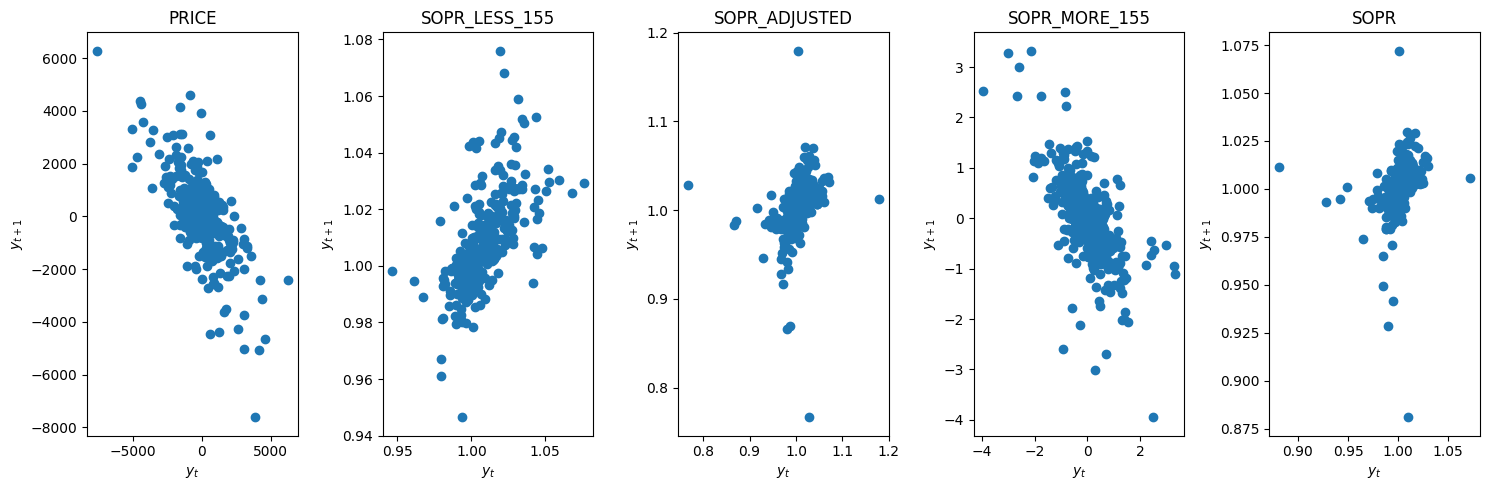

In [225]:
lag_plots(df)

In [226]:
kpss_test(df)

,PRICE,SOPR_LESS_155,SOPR_ADJUSTED,SOPR_MORE_155,SOPR
Test statistic,0.1194,0.1798,0.2054,0.0198,0.2012
p-value,0.0992,0.0236,0.0140,0.1000,0.0156
Critical value - 1%,0.2160,0.2160,0.2160,0.2160,0.2160
Critical value - 2.5%,0.1760,0.1760,0.1760,0.1760,0.1760
Critical value - 5%,0.1460,0.1460,0.1460,0.1460,0.1460
Critical value - 10%,0.1190,0.1190,0.1190,0.1190,0.1190


In [227]:

adf_test(df)

,PRICE,SOPR_LESS_155,SOPR_ADJUSTED,SOPR_MORE_155,SOPR
Test statistic,-10.2828,-3.8352,-5.5079,-10.0155,-5.7669
p-value,0.0000,0.0026,0.0000,0.0000,0.0000
Critical value - 1%,-3.4495,-3.4489,-3.4487,-3.4495,-3.4487
Critical value - 5%,-2.8700,-2.8697,-2.8696,-2.8700,-2.8696
Critical value - 10%,-2.5713,-2.5711,-2.5711,-2.5713,-2.5711


In [228]:
#Split the data into train and test sets for the VAR model.
def splitter(data_df):
    end = round(len(data_df)*.8)
    train_df = data_df[:end]
    test_df = data_df[end:]
    return train_df, test_df

In [229]:
train_df, test_df = splitter(df)

In [230]:
# Select the VAR order 𝑝 by computing the different multivariate information criteria (AIC, BIC, HQIC), and FPE.
def select_p(train_df):
    aic, bic, fpe, hqic = [], [], [], []
    model = VAR(train_df) 
    p = np.arange(1,60)
    for i in p:
        result = model.fit(i)
        aic.append(result.aic)
        bic.append(result.bic)
        fpe.append(result.fpe)
        hqic.append(result.hqic)
    lags_metrics_df = pd.DataFrame({'AIC': aic, 
                                    'BIC': bic, 
                                    'HQIC': hqic,
                                    'FPE': fpe}, 
                                   index=p)    
    fig, ax = plt.subplots(1, 4, figsize=(15, 3), sharex=True)
    lags_metrics_df.plot(subplots=True, ax=ax, marker='o')
    plt.tight_layout()
    print(lags_metrics_df.idxmin(axis=0))

AIC     59
BIC     59
HQIC    59
FPE     49
dtype: int64


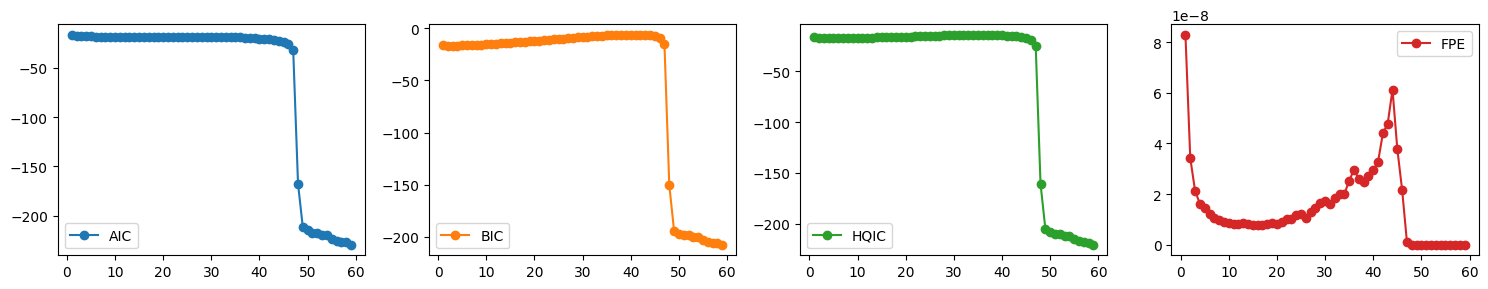

In [240]:
select_p(train_df)

In [241]:
p = 10
model = VAR(train_df)
var_model = model.fit(p)

In [242]:
def granger_causation_matrix(data, variables, p, test = 'ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the time series.
    The rows are the response variables, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], p, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(p)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [243]:
granger_causation_matrix(train_df, train_df.columns, p)  

,PRICE_x,SOPR_LESS_155_x,SOPR_ADJUSTED_x,SOPR_MORE_155_x,SOPR_x
PRICE_y,1.0000,0.0000,0.0001,0.1346,0.0009
SOPR_LESS_155_y,0.0000,1.0000,0.0044,0.0529,0.0131
SOPR_ADJUSTED_y,0.0343,0.0003,1.0000,0.1576,0.0244
SOPR_MORE_155_y,0.0702,0.0336,0.0000,1.0000,0.0000
SOPR_y,0.0651,0.0009,0.0205,0.1985,1.0000


<Axes: >

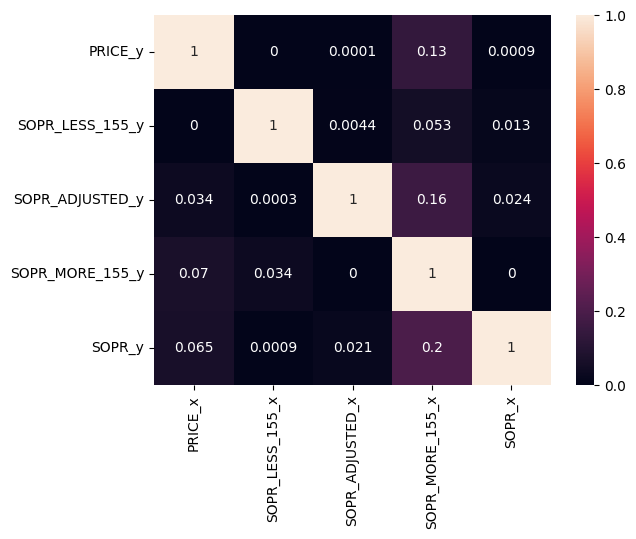

In [244]:
sns.heatmap(granger_causation_matrix(train_df, train_df.columns, p)  , annot=True)